# DeepFace Detection

In [2]:
# TERMS ::

# Boundary Box
# label me library
# Annonating image
# Data Augmentation
# Arbumentation Library

# 1. SetUp and Get Data

### 1.1 Install Dependencies

In [3]:
# ! pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images using Opencv

In [4]:
import os
import time
import uuid
import cv2

In [5]:
IMAGES_PATH = os.path.join('data','images')  # Define the path where images will be saved
number_images = 30                           # Number of images to collect

In [6]:
os.makedirs(IMAGES_PATH, exist_ok=True)

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))  # Print a message showing which image is being collected
    ret, frame = cap.read()                      # Capture a frame from the camera
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')    # Generate a unique image name
    cv2.imwrite(imgname, frame)                   # Save the captured frame as an image
    cv2.imshow('frame', frame)                    # Display the captured frame
    time.sleep(0.5)                               # Wait for a short period

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annonate Images using LabelMe

In [8]:
# ! labelme

# 2. Review Dataset and Build Image Loading Function
### 2.1 Import TF and Deps

In [9]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### 2.3 Load Image into Tf Data Pipeline

In [12]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False) # List all image files in the directory

In [13]:
images.as_numpy_iterator().next()       # Get the first image file path

b'data\\images\\fa5e6c72-403a-11ef-93a7-b4b5b6aa98de.jpg'

In [14]:
def load_image(x):
    byte_img = tf.io.read_file(x)           # Read the image file
    img = tf.io.decode_jpeg(byte_img)       # Decode the JPEG image
    return img                              # Return the decoded image

In [15]:
images = images.map(load_image)             # Apply the load_image function to each image file

In [16]:
images.as_numpy_iterator().next()  # Get the first image tensor

array([[[ 9, 18, 15],
        [ 8, 17, 14],
        [ 7, 16, 13],
        ...,
        [ 7, 11, 12],
        [ 7, 11, 14],
        [ 7, 11, 14]],

       [[ 9, 18, 15],
        [ 8, 17, 14],
        [ 7, 16, 13],
        ...,
        [ 8, 12, 13],
        [ 8, 12, 15],
        [ 8, 12, 15]],

       [[ 8, 17, 14],
        [ 8, 17, 14],
        [ 8, 17, 14],
        ...,
        [ 8, 12, 13],
        [ 8, 12, 13],
        [ 8, 12, 13]],

       ...,

       [[ 3,  7,  6],
        [ 3,  7,  6],
        [ 4,  8,  7],
        ...,
        [ 5, 13, 15],
        [ 5, 13, 15],
        [ 5, 13, 15]],

       [[ 4,  8,  7],
        [ 4,  8,  7],
        [ 4,  8,  7],
        ...,
        [ 5, 13, 15],
        [ 5, 13, 15],
        [ 5, 13, 15]],

       [[ 5,  9,  8],
        [ 5,  9,  8],
        [ 5,  9,  8],
        ...,
        [ 5, 13, 15],
        [ 5, 13, 15],
        [ 6, 14, 16]]], dtype=uint8)

In [17]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [18]:
image_generator = images.batch(4).as_numpy_iterator()  # Batch the images into groups of 4

In [19]:
plot_images = image_generator.next()  # Get the first batch of images

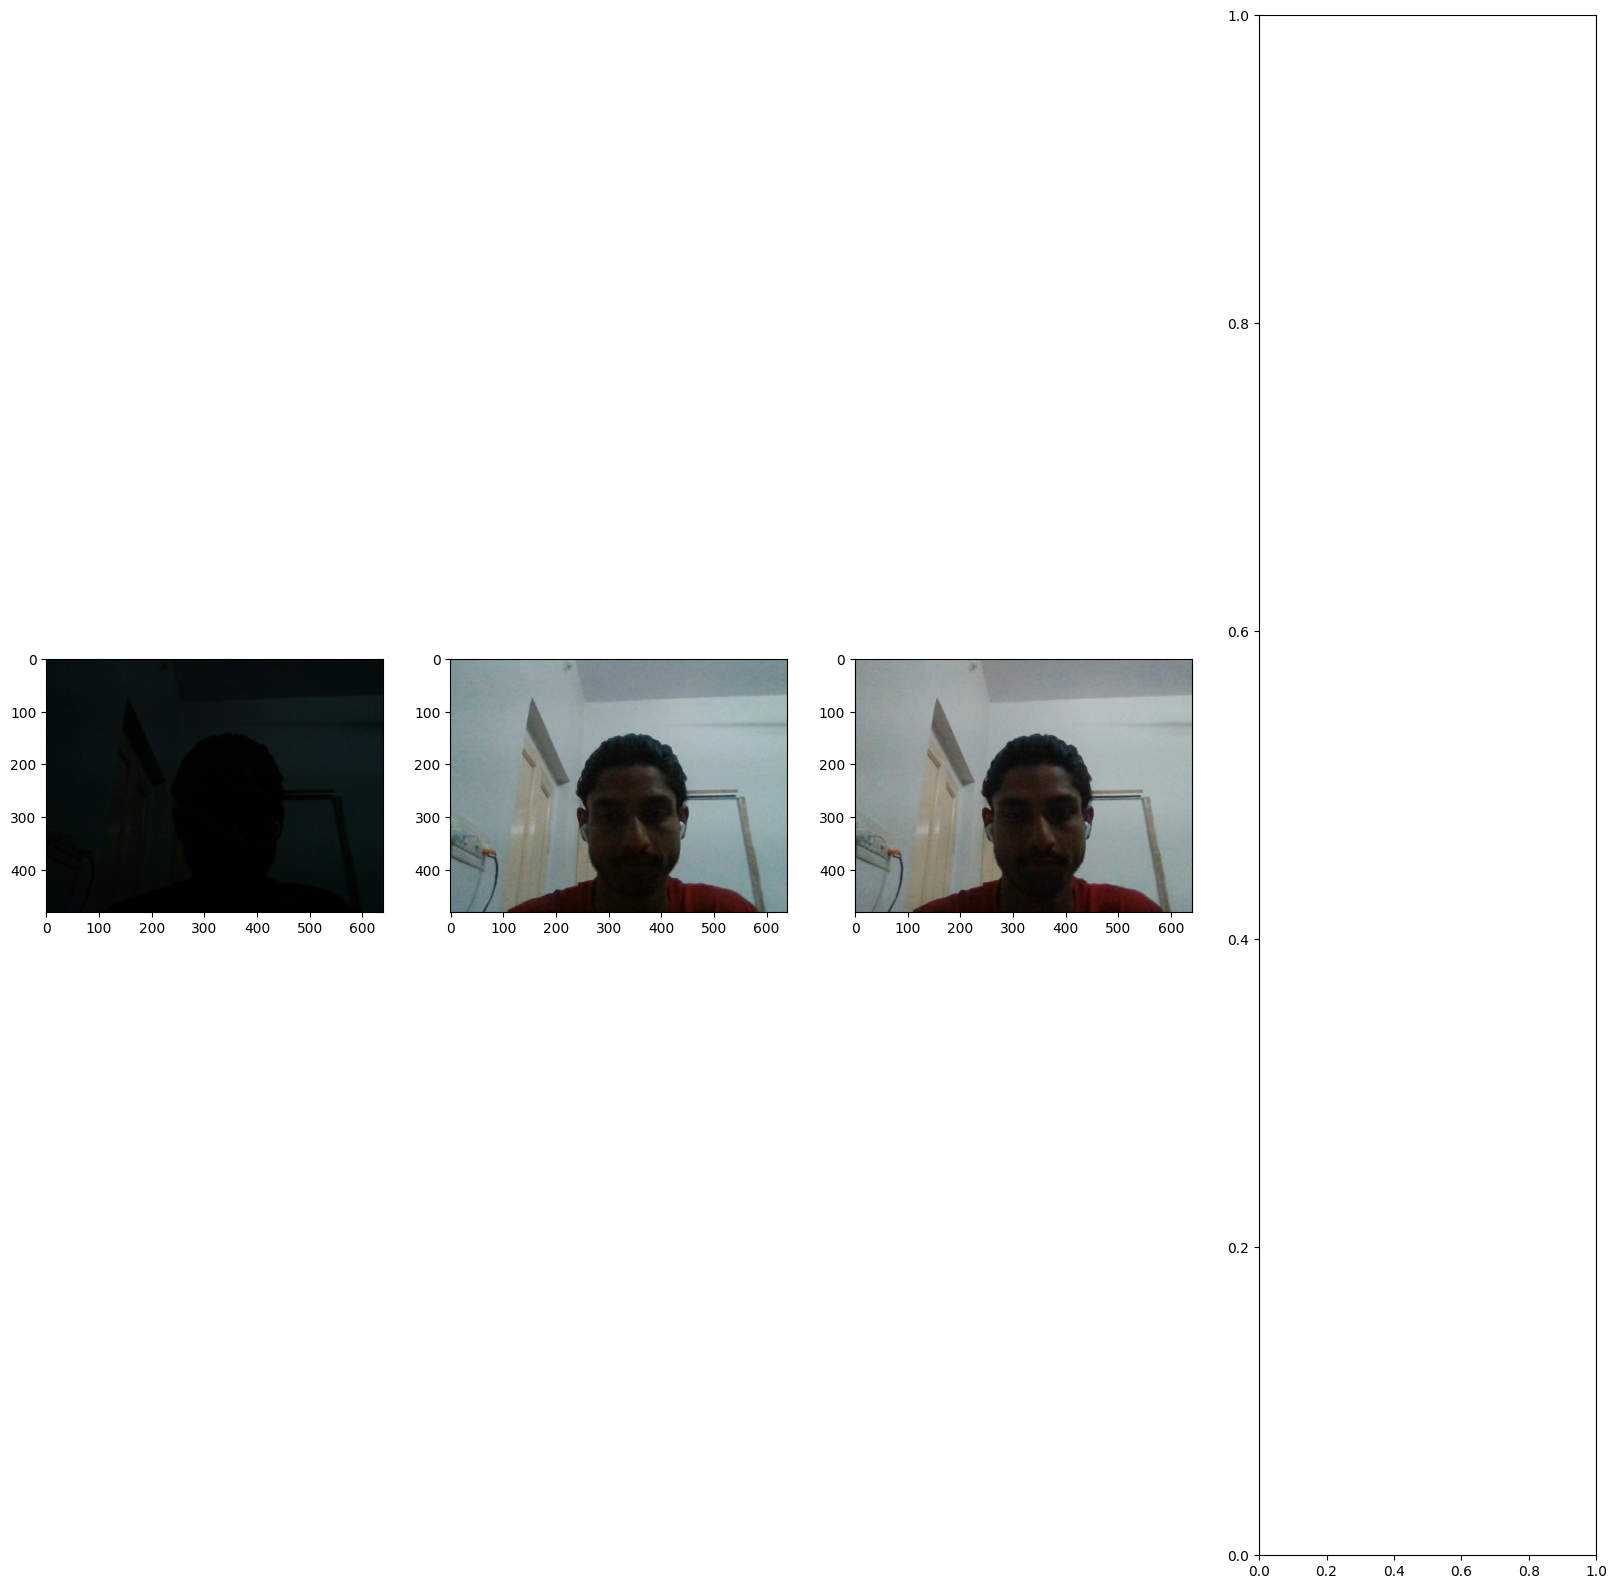

In [20]:
fix, ax = plt.subplots(ncols=4 , figsize=(20,20))  # Create a plot with 4 columns and a large figure size
for idx , image in enumerate(plot_images):  # Loop through each image in the batch
    ax[idx].imshow(image)                   # Display the image in the corresponding subplot
plt.show()                                  # Show the plot

# 3. Partition Unaugmented Data
### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [21]:
90*.7 # 63 to train
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [22]:
for folder in ['train', 'test', 'val']:  # Loop through each folder ('train', 'test', 'val')
    for file in os.listdir(os.path.join('data', folder, 'images')):  # Loop through each file in the 'images' subfolder of the current folder

        filename = file.split('.')[0] + '.json'  # Generate the corresponding JSON filename by replacing the file extension with '.json'
        existing_filepath = os.path.join('data', 'labels', filename)  # Create the path to the existing label file

        if os.path.exists(existing_filepath):  # Check if the existing label file exists
            new_filepath = os.path.join('data', folder, 'labels', filename)  # Create the new path to move the label file to the appropriate 'labels' subfolder
            os.replace(existing_filepath, new_filepath)  # Move the existing label file to the new path

# 4. Apply Image Augmentation on Images and Labels using Albumentations
### 4.1 Setup Albumentations Transform Pipeline

In [23]:
! pip install albumentations

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Dipanshu\\AIML\\PROJECTS\\DEEPFACE\\myenv\\Lib\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



In [24]:
import numpy as np

In [25]:
import albumentations as alb

In [26]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                        alb.HorizontalFlip(p=0.5), 
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2), 
                        alb.RGBShift(p=0.2), 
                        alb.VerticalFlip(p=0.5)], 
                        bbox_params=alb.BboxParams(format='albumentations',     label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [27]:
img = cv2.imread(os.path.join('data','train', 'images','1a3f07ba-3e1d-11ef-9e63-b4b5b6aa98de.jpg'))

In [28]:
with open(os.path.join('data', 'train', 'labels', '1a3f07ba-3e1d-11ef-9e63-b4b5b6aa98de.json'), 'r') as f:
    label = json.load(f)

### 4.3 Extract Coordinates and Rescale to Match Image Resolution


In [29]:
coords = label['shapes'][0]['points']
coords = [coord for point in coords for coord in point]  # Flatten the list of points
coords  # Check the flattened coordinates

[202.9268292682927, 53.821138211382106, 422.43902439024396, 296.0975609756097]

In [30]:
# Assuming original image dimensions
orig_height, orig_width = img.shape[:2]
coords = list(np.divide(coords, [orig_width, orig_height, orig_width, orig_height]))  # Corrected rescaling
coords  # Check the rescaled coordinates

[0.3170731707317073,
 0.11212737127371272,
 0.6600609756097562,
 0.616869918699187]

In [31]:
# Apply augmentations
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
type(augmented)
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

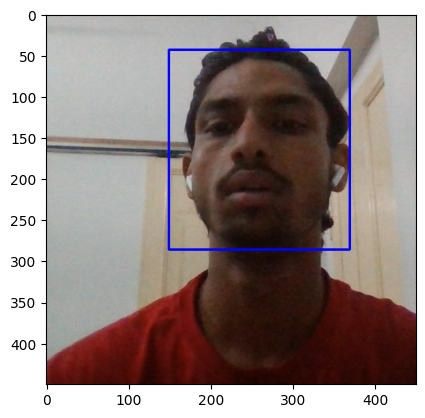

In [32]:
# Verify if the augmented bounding boxes contain coordinates
if augmented['bboxes']:  # Corrected the check for bounding boxes
    bbox = augmented['bboxes'][0]
    bbox  # Check the bounding box coordinates
    start_point = tuple(np.multiply(bbox[:2], [450, 450]).astype(int))  # Corrected indexing for start_point
    end_point = tuple(np.multiply(bbox[2:], [450, 450]).astype(int))  # Corrected indexing for end_point

    cv2.rectangle(augmented['image'], start_point, end_point, (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB))  # Corrected the color conversion for plt.imshow
    plt.show()
else:
    print("No bounding boxes found in the augmented image.")  # Added this print statement for debugging

## 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [33]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.26117886178861793, 0.6829268292682926, 0.002032520325203313, 0.2154471544715447, 'face'].
x_max is less than or equal to x_min for bbox [0.30309959349593496, 0.6676829268292682, -4.4408920985006264e-17, 0.1994803027298565, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [34]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x / 255)

In [35]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x / 255)

In [36]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x / 255)

In [37]:
train_images.as_numpy_iterator().next()

array([[[0.24546568, 0.12585784, 0.10870098],
        [0.26795343, 0.11893383, 0.10716911],
        [0.27058825, 0.13333334, 0.11764706],
        ...,
        [0.5168505 , 0.21556373, 0.19460784],
        [0.47561276, 0.22800244, 0.21691176],
        [0.42726716, 0.25379902, 0.23903187]],

       [[0.25275734, 0.12677696, 0.11648285],
        [0.27156863, 0.12254902, 0.11862745],
        [0.26231617, 0.12506127, 0.11721814],
        ...,
        [0.52463233, 0.24129902, 0.21905637],
        [0.4632353 , 0.26127452, 0.24466912],
        [0.49387255, 0.4079657 , 0.3716299 ]],

       [[0.24258578, 0.11531863, 0.10502451],
        [0.26237744, 0.11335784, 0.10943627],
        [0.25343138, 0.11960784, 0.11176471],
        ...,
        [0.46348038, 0.2125    , 0.20465687],
        [0.44215685, 0.30447304, 0.2857843 ],
        [0.60900736, 0.5822304 , 0.5469363 ]],

       ...,

       [[0.7642157 , 0.7710784 , 0.74607843],
        [0.74944854, 0.7572917 , 0.73768383],
        [0.7411765 , 0

## Prepare Labels

### 6.1 Build Label Loading Function

In [38]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [39]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2303, 0.371 , 0.6006, 0.877 ], dtype=float16))

## 7. Combine Label and Image Samples
### 7.1 Check Partition Lengths

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3480, 3480, 660, 660, 840, 840)

### 7.2 Create Final Datasets (Images/Labels)

In [44]:
train = tf.data.Dataset.zip((train_images,train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [45]:
test = tf.data.Dataset.zip((train_images,train_labels))
test = train.shuffle(1300)
test = train.batch(8)
test = train.prefetch(4)

In [46]:
val = tf.data.Dataset.zip((train_images,train_labels))
val = train.shuffle(1000)
val = train.batch(8)
val = train.prefetch(4)

In [47]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.2908, 0.3875, 0.822 ],
        [0.1876, 0.1573, 0.621 , 0.674 ],
        [0.3015, 0.2314, 0.825 , 0.837 ],
        [0.1688, 0.1482, 0.5845, 0.647 ],
        [0.468 , 0.3096, 0.683 , 0.7866],
        [0.    , 0.2896, 0.371 , 0.974 ],
        [0.607 , 0.1678, 0.9756, 0.6104],
        [0.2468, 0.2698, 0.8306, 0.8135]], dtype=float16))

### 7.3 View Images and Annotations

In [48]:
data_samples = train.as_numpy_iterator()

In [49]:
res = data_samples.next()

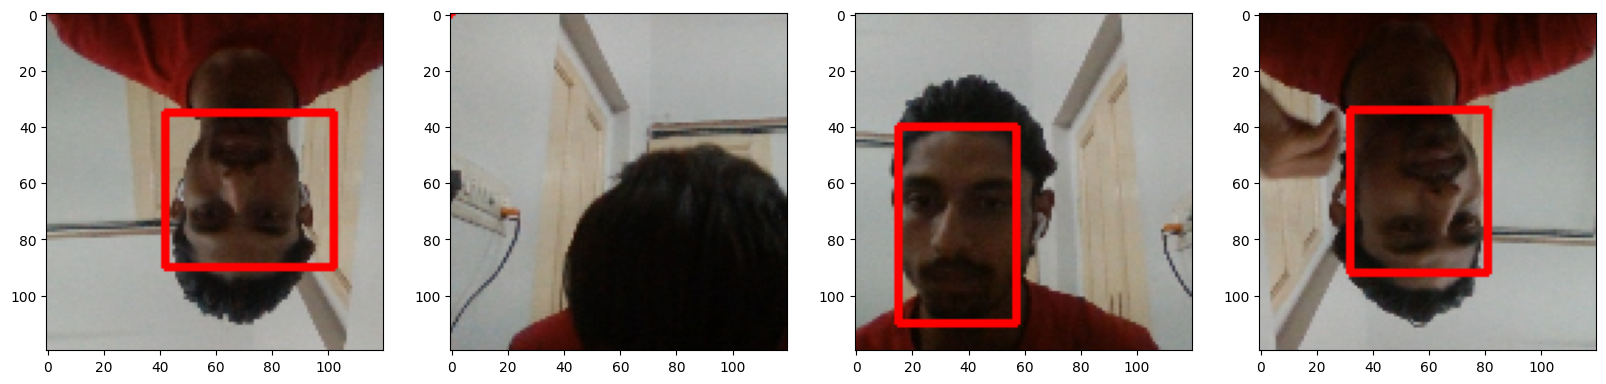

In [50]:
# Plotting the sample image with bounding box
res = train.as_numpy_iterator().next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx].copy()  # Create a copy of the image array to avoid the read-only error
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)
    
    ax[idx].imshow(sample_image)
plt.show()


## 8. Build Deep Learning using Function API
### 8.1 Import Layers and Base Network

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [52]:
vgg = VGG16(include_top=False)

In [53]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [54]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [55]:
facetracker = build_model()

In [56]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
X, y = train.as_numpy_iterator().next()

In [58]:
X.shape

(8, 120, 120, 3)

In [59]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [60]:
classes, coords

(array([[0.4589203 ],
        [0.5200807 ],
        [0.48301584],
        [0.5037241 ],
        [0.48546603],
        [0.43614966],
        [0.44179752],
        [0.50933695]], dtype=float32),
 array([[0.33373094, 0.37190863, 0.57245404, 0.1931926 ],
        [0.419611  , 0.44708076, 0.5805892 , 0.18352059],
        [0.32574055, 0.48229334, 0.54772615, 0.21573676],
        [0.3152503 , 0.4237256 , 0.569543  , 0.20499383],
        [0.3555447 , 0.34418467, 0.55860305, 0.18885872],
        [0.3209427 , 0.4367878 , 0.50255156, 0.23135586],
        [0.26074964, 0.42307895, 0.5278558 , 0.18554935],
        [0.34832188, 0.491853  , 0.55407745, 0.20032346]], dtype=float32))

## 9. Define Losses and Optimizers
### 9.1 Define Optimizer and LR

In [61]:
len(train)

435

In [62]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [63]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

c:\Users\Dipanshu\AIML\PROJECTS\DEEPFACE\myenv\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### 9.2 Create Localization Loss and Classification Loss


In [64]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [65]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [68]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.4299603>

In [69]:
localization_loss(y[1], coords).numpy()

4.4299603

In [70]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7362559>

In [71]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.4299603>

## 10. Train Neural Network
### 10.1 Create Custom Model Class

In [79]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs): 
        X, y = batch
        
        # Ensure the shapes are explicitly set for the labels
        y[0].set_shape([None, 1])
        y[1].set_shape([None, 4])
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        # Ensure the shapes are explicitly set for the labels
        y[0].set_shape([None, 1])
        y[1].set_shape([None, 4])
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [80]:
model = FaceTracker(facetracker)

In [81]:
model.compile(opt, classloss, regressloss)

### 10.2 Train


In [82]:
logdir='logs'

In [83]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [99]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])   

Epoch 1/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 1230s 3s/step - class_loss: 0.0114 - regress_loss: 0.0649 - total_loss: 0.0706 - val_class_loss: 1.0795e-04 - val_regress_loss: 0.0338 - val_total_loss: 0.0339
Epoch 2/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 828s 2s/step - class_loss: 0.0057 - regress_loss: 0.0303 - total_loss: 0.0331 - val_class_loss: 2.2527e-05 - val_regress_loss: 0.0169 - val_total_loss: 0.0169
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 745s 2s/step - class_loss: 0.0043 - regress_loss: 0.0222 - total_loss: 0.0243 - val_class_loss: 5.3943e-05 - val_regress_loss: 0.0207 - val_total_loss: 0.0207
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 941s 2s/step - class_loss: 0.0060 - regress_loss: 0.0270 - total_loss: 0.0300 - val_class_loss: 9.6596e-04 - val_regress_loss: 0.0173 - val_total_loss: 0.0178
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 991s 2s/step - class_loss: 0.0032 - regress_loss: 0.0265 - total_loss: 0.0281 - val_class_loss: 0.0464 - val_regress_loss: 0.1236 - val_total_loss: 0.1468
Epoch 6/

In [100]:
hist.history

{'class_loss': [0.00022354829707182944,
  1.105864612327423e-05,
  0.0001234684168593958,
  0.008202483877539635,
  0.005119401030242443,
  0.011837651953101158,
  4.960837395628914e-05,
  1.9652014088933356e-05,
  9.631946159061044e-05,
  1.6211126421694644e-05],
 'regress_loss': [0.06948495656251907,
  0.025097230449318886,
  0.031226402148604393,
  0.03262285143136978,
  0.10858331620693207,
  0.0189908966422081,
  0.006760677322745323,
  0.022286109626293182,
  0.028275292366743088,
  0.013603465631604195],
 'total_loss': [0.06959673017263412,
  0.025102760642766953,
  0.031288135796785355,
  0.03672409430146217,
  0.11114301532506943,
  0.024909723550081253,
  0.0067854817025363445,
  0.022295935079455376,
  0.028323452919721603,
  0.013611570931971073],
 'val_class_loss': [0.000107953128463123,
  2.2527281544171274e-05,
  5.394340041675605e-05,
  0.0009659576462581754,
  0.04644656553864479,
  0.000323186133755371,
  0.0006588411633856595,
  2.9974577046232298e-05,
  0.0003343731

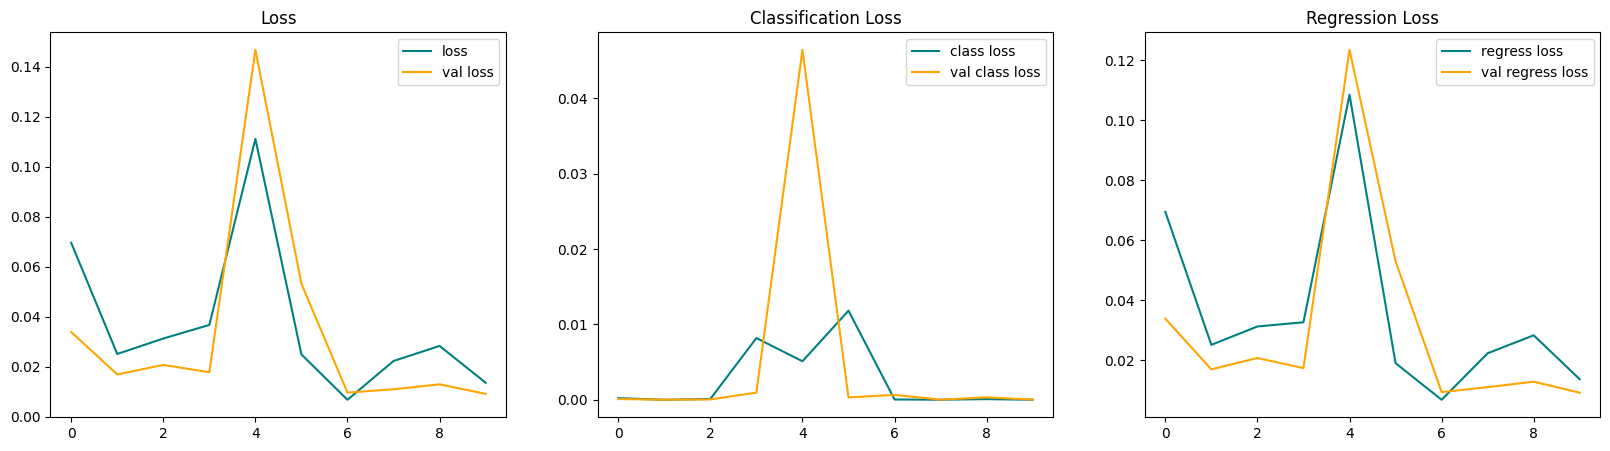

In [101]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## 11. Make Predictions
### 11.1 Make Predictions on Test Set

In [102]:
test_data = test.as_numpy_iterator()

In [103]:
test_sample = test_data.next()

In [104]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


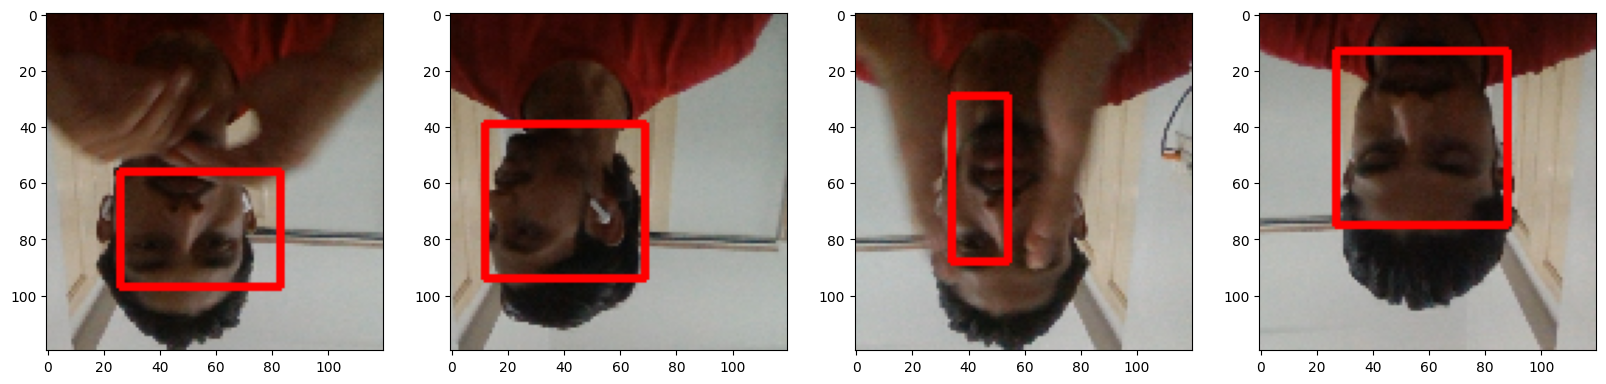

In [106]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()  # Create a copy of the image array to avoid the read-only error
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)
plt.show()


### 11.2 Save the Model


In [107]:
from tensorflow.keras.models import load_model

In [108]:
facetracker.save('facetracker.h5')

In [109]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection



In [112]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━